# Arbol de Decision

In [59]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [32]:
# Tengo que recargar el archivo para que tome los cambios que se hicieron en el mismo

import importlib, sys

importlib.reload(sys.modules['Preprocessing'])
from Preprocessing import *

In [33]:
df = preprod_tp1(df_data, df_decision)
df = replace_nulls_edad(df, 'media')
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,117,hombre,73.5,0,0,1,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,1,1,2,fiumark_quilmes,2,0
2,normal,794,hombre,32.7,0,0,3,fiumark_chacarita,0,0
3,4d,455,hombre,32.7,0,0,1,fiumark_palermo,0,0
4,4d,173,mujer,4.0,1,1,2,fiumark_palermo,2,1


In [34]:
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2,0
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2,1


In [35]:
# TODO: pasar a preprocessing.py
#columnsTitles=["tipo_de_sala","nombre","id_usuario","genero","edad","amigos",
#               "parientes","precio_ticket",'nombre_sede','cant_acompañantes','volveria']
#df = df.reindex(columns=columnsTitles)
#df.head()

In [36]:
df.shape

(801, 15)

# Entrenamiento

In [37]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [38]:
X.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2


In [39]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

In [41]:
max_depths = np.arange(1, 25)
min_samples_leafs = np.arange(1, 51)
data_points = []
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        clf = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=117
        )
        clf.fit(X_train, y_train)
        data_points.append(
            (max_depth, min_samples_leaf, accuracy_score(y_test, clf.predict(X_test)),)
        )

data_points = pd.DataFrame(
    data_points, columns=["max_depth", "min_samples_leaf", "score"]
)

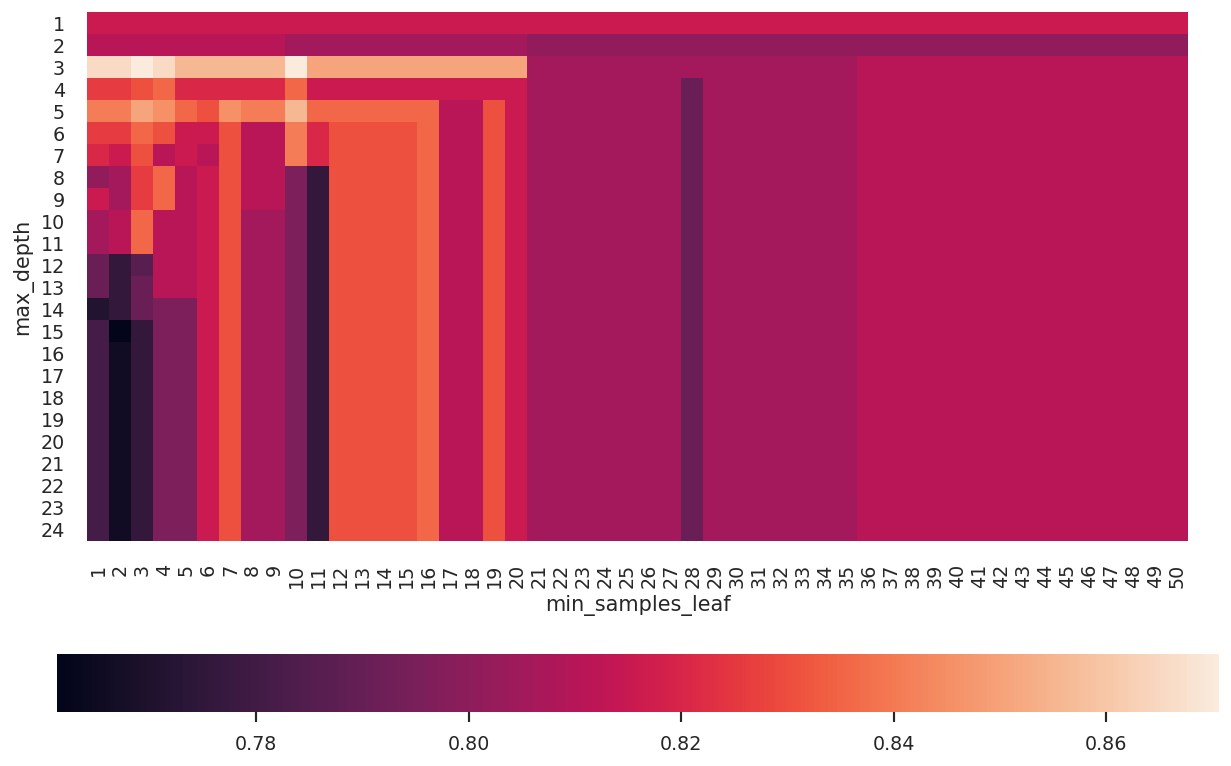

In [42]:
plt.figure(dpi=125, figsize=(12, 8))
g = sns.heatmap(
    data_points.pivot_table(
        index="max_depth", columns="min_samples_leaf", values="score"
    ),
    square=True,
    cbar_kws=dict(use_gridspec=False, location="bottom"),
)

# Baseline

Entrenamos el modelo considerando parametros que nos parecen razonables, en base a lo visto anteriormente

In [43]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=117)

# Metricas

### Accuracy

In [60]:
accuracy_score(y_test, clf.predict(X_test))

0.8706467661691543

### Precision

In [61]:
precision_score(y_test, clf.predict(X_test))

0.8636363636363636

### Recall

In [62]:
recall_score(y_test, clf.predict(X_test), pos_label=0)

0.9291338582677166

### F1-Score

In [63]:
f1_score(y_test, clf.predict(X_test))

0.8142857142857143

### Matriz de cofusion

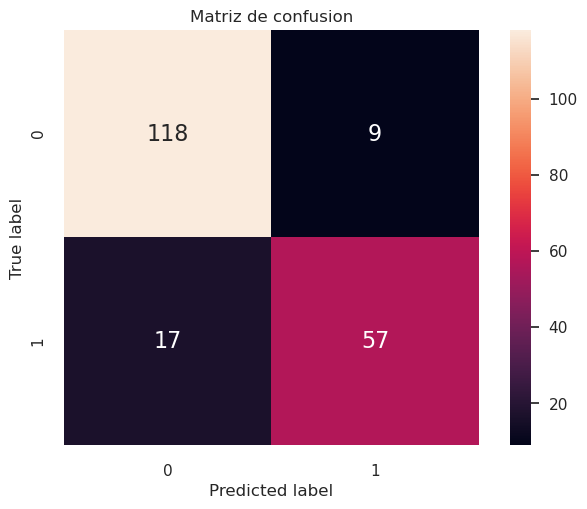

In [64]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, clf.predict(X_test))

### Curva AUC ROC

In [65]:



def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

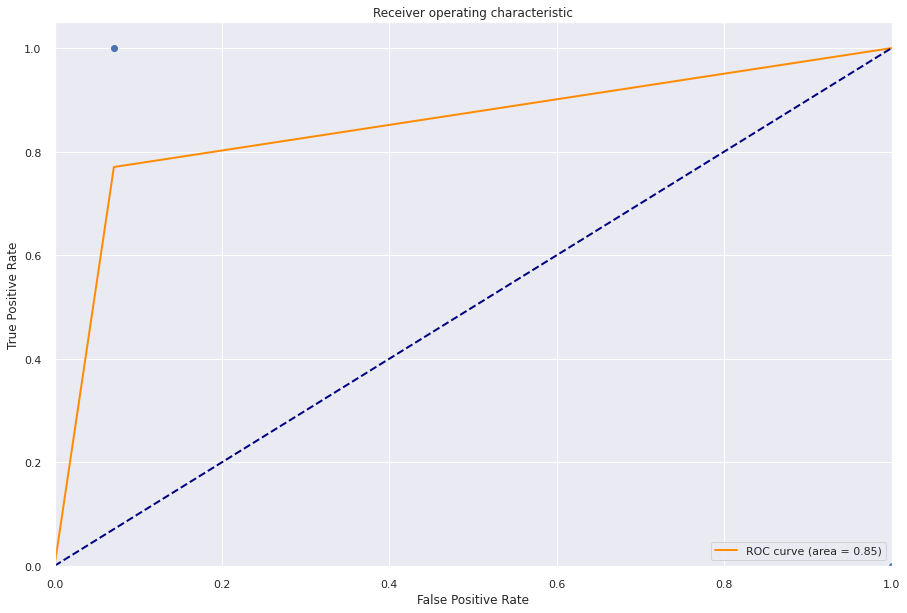

0.8497020642689933

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_test, clf.predict(X_test)))